In [1]:
# libraries and modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, homogeneity_completeness_v_measure
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from folium.plugins import HeatMap
from kneed import KneeLocator

In [2]:
# import data
wrangled = pd.read_csv('../data/processed/dog_bite_wrangled.csv')

# display
wrangled.head()

,date_of_bite,year,month,day,day_of_week,borough,zip_code,latitude,longitude,spay_neuter,...,pit_bull,german_shepherd,shih_tzu,chihuahua,yorkshire_terrier,bull_dog,labrador_retriever,maltese,husky,standard_poodle
0,2018-01-01,2018,1,1,0,brooklyn,11220,40.641026,-74.016688,False,...,False,False,False,False,False,False,False,False,False,False
1,2018-01-06,2018,1,6,5,brooklyn,11224,40.577372,-73.988706,False,...,True,False,False,False,False,False,False,False,False,False
2,2018-01-08,2018,1,8,0,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,False
3,2018-01-09,2018,1,9,1,brooklyn,11224,40.577372,-73.988706,False,...,True,False,False,False,False,False,False,False,False,False
4,2018-01-03,2018,1,3,2,brooklyn,11231,40.677916,-74.005154,False,...,False,False,False,False,False,False,False,False,False,False


In [3]:
# drop other data
feats_to_keep = ['date_of_bite', 'zip_code']
prep_final = wrangled[feats_to_keep]

prep_final.head()

,date_of_bite,zip_code
0,2018-01-01,11220
1,2018-01-06,11224
2,2018-01-08,11231
3,2018-01-09,11224
4,2018-01-03,11231


In [4]:
df = prep_final.copy()

In [5]:
df['date_of_bite'] = pd.to_datetime(df['date_of_bite'])
df['year_week'] = df['date_of_bite'].dt.strftime('%Y-%U')

df.head()

,date_of_bite,zip_code,year_week
0,2018-01-01,11220,2018-00
1,2018-01-06,11224,2018-00
2,2018-01-08,11231,2018-01
3,2018-01-09,11224,2018-01
4,2018-01-03,11231,2018-00


In [6]:
weekly_trends = df.groupby(['zip_code', 'year_week']).size().reset_index(name='bite_count')

weekly_trends.head()

,zip_code,year_week,bite_count
0,10001,2015-09,1
1,10001,2015-17,1
2,10001,2016-29,1
3,10001,2016-31,1
4,10001,2016-32,1


In [7]:
pivot_data = weekly_trends.pivot(index='zip_code', columns='year_week', values='bite_count').fillna(0)

pivot_data.head()

year_week,2015-00,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,...,2022-43,2022-44,2022-45,2022-46,2022-47,2022-48,2022-49,2022-50,2022-51,2022-52
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10002,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0
10003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
n_lags = 5  # Choose `n_lags` based on your needs

lagged_data = pivot_data.copy()

for lag in range(1, n_lags + 1):
    shifted = pivot_data.shift(lag, axis=1)
    shifted.columns = [f'lag_{lag}_{col}' for col in shifted.columns]
    lagged_data = pd.concat([lagged_data, shifted], axis=1)

# Drop the original columns
lagged_data = lagged_data.iloc[:, pivot_data.shape[1]:]

lagged_data.head()

,lag_1_2015-00,lag_1_2015-01,lag_1_2015-02,lag_1_2015-03,lag_1_2015-04,lag_1_2015-05,lag_1_2015-06,lag_1_2015-07,lag_1_2015-08,lag_1_2015-09,...,lag_5_2022-43,lag_5_2022-44,lag_5_2022-45,lag_5_2022-46,lag_5_2022-47,lag_5_2022-48,lag_5_2022-49,lag_5_2022-50,lag_5_2022-51,lag_5_2022-52
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10002,NaN,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
10003,NaN,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
10004,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10005,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
normalized_data = scaler.fit_transform(lagged_data.dropna(axis=1))  # Drop NaN columns if applicable

normalized_data = pd.DataFrame(normalized_data, columns=lagged_data.dropna(axis=1).columns)

normalized_data.head()

,lag_1_2015-01,lag_1_2015-02,lag_1_2015-03,lag_1_2015-04,lag_1_2015-05,lag_1_2015-06,lag_1_2015-07,lag_1_2015-08,lag_1_2015-09,lag_1_2015-10,...,lag_5_2022-43,lag_5_2022-44,lag_5_2022-45,lag_5_2022-46,lag_5_2022-47,lag_5_2022-48,lag_5_2022-49,lag_5_2022-50,lag_5_2022-51,lag_5_2022-52
0,-0.271041,-0.408514,-0.375217,-0.447616,-0.412231,-0.442709,-0.420021,-0.461157,-0.432201,1.417399,...,1.583230,-0.466569,-0.470117,-0.402911,-0.357154,-0.443310,-0.490195,1.208418,-0.360342,-0.386582
1,-0.271041,-0.408514,2.112334,-0.447616,-0.412231,3.159331,1.611972,-0.461157,-0.432201,-0.394847,...,1.583230,-0.466569,-0.470117,-0.402911,-0.357154,-0.443310,1.165369,1.208418,2.327212,-0.386582
2,-0.271041,-0.408514,-0.375217,-0.447616,2.425823,-0.442709,-0.420021,-0.461157,-0.432201,1.417399,...,1.583230,-0.466569,-0.470117,-0.402911,-0.357154,1.446036,1.165369,-0.430270,-0.360342,-0.386582
3,-0.271041,1.876613,-0.375217,-0.447616,-0.412231,-0.442709,-0.420021,-0.461157,-0.432201,-0.394847,...,-0.455606,-0.466569,-0.470117,-0.402911,-0.357154,-0.443310,-0.490195,-0.430270,-0.360342,-0.386582
4,-0.271041,-0.408514,-0.375217,-0.447616,-0.412231,-0.442709,-0.420021,-0.461157,-0.432201,-0.394847,...,-0.455606,-0.466569,-0.470117,-0.402911,-0.357154,-0.443310,-0.490195,-0.430270,-0.360342,-0.386582


c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows wi

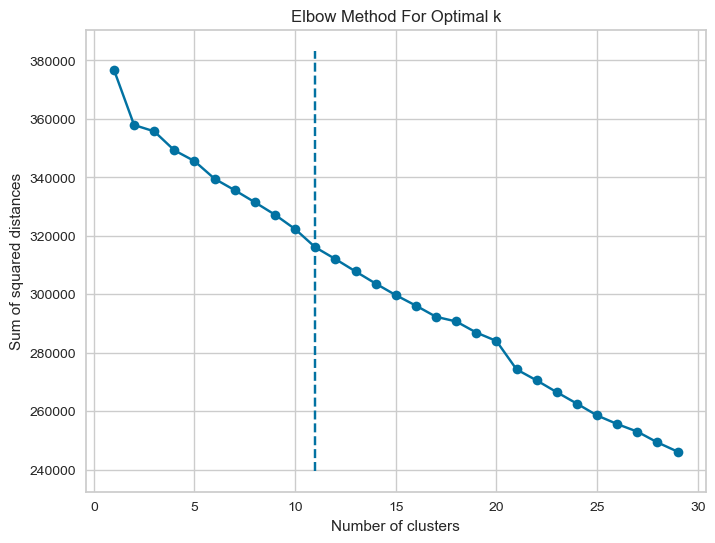

The optimal number of clusters is: 11


In [10]:
from kneed import KneeLocator

# Calculate the sum of squared distances for a range of cluster numbers
sse = []
k_range = range(1, 30)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_data)
    sse.append(kmeans.inertia_)

# Use KneeLocator to find the elbow point
kneedle = KneeLocator(k_range, sse, curve='convex', direction='decreasing')
elbow_point = kneedle.elbow

# Plot the elbow
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, 'bo-')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')
plt.vlines(elbow_point, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.show()

print(f'The optimal number of clusters is: {elbow_point}')

In [11]:
from sklearn.cluster import KMeans

n_clusters = elbow_point  # Choose `n_clusters` based on the elbow point

kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Choose `num_clusters` as needed
clusters = kmeans.fit_predict(normalized_data)

# Assign cluster labels back to boroughs
pivot_data['cluster'] = clusters

pivot_data.head()

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


year_week,2015-00,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,...,2022-44,2022-45,2022-46,2022-47,2022-48,2022-49,2022-50,2022-51,2022-52,cluster
zip_code,,,,,,,,,,,,,,,,,,,,,
10001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
10002,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,2
10003,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
10004,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
10005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


In [12]:
zip_code_cluster_counts = pivot_data['cluster'].value_counts()
print(zip_code_cluster_counts)

cluster
2     152
0       9
1       9
8       2
10      1
4       1
6       1
5       1
7       1
3       1
9       1
Name: count, dtype: int64


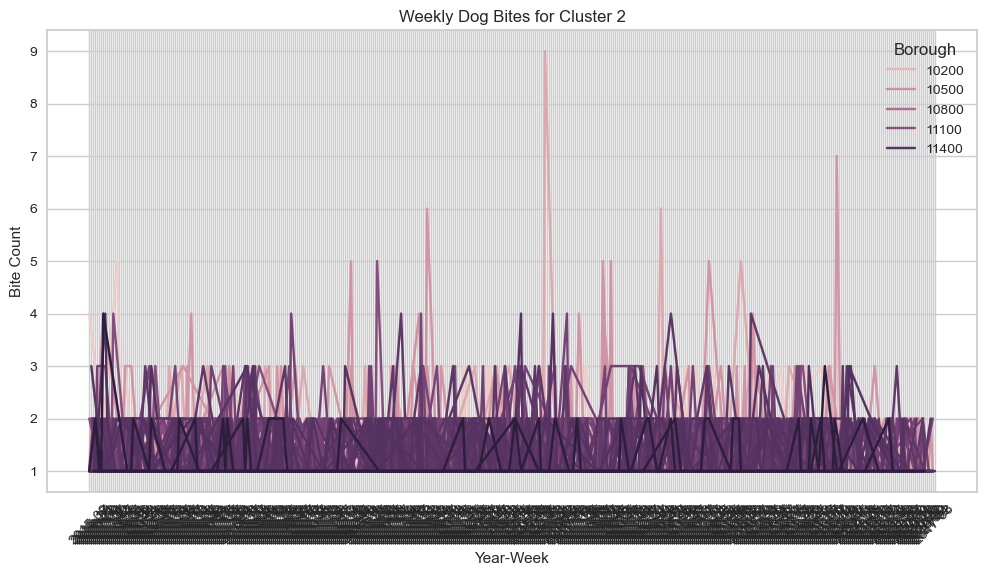

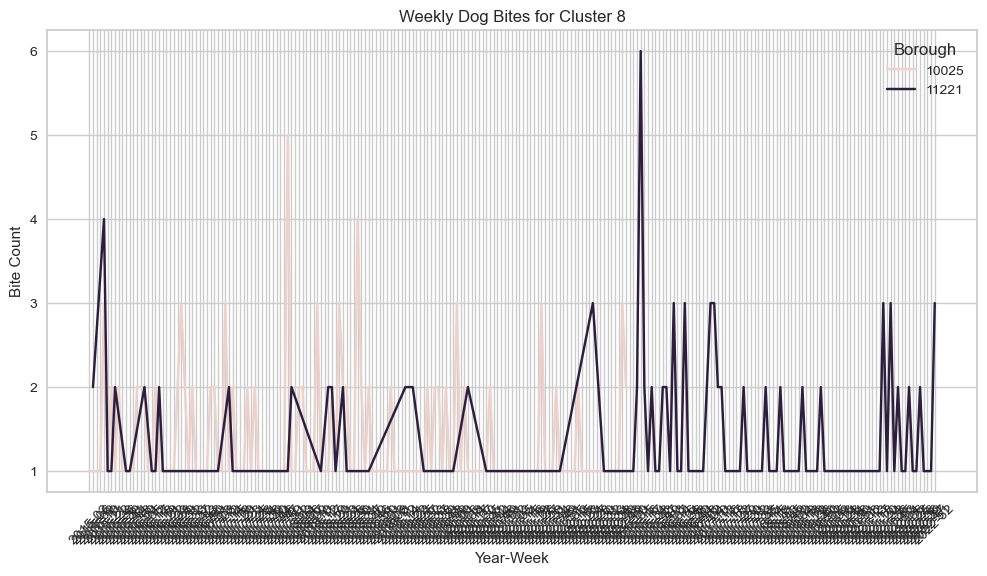

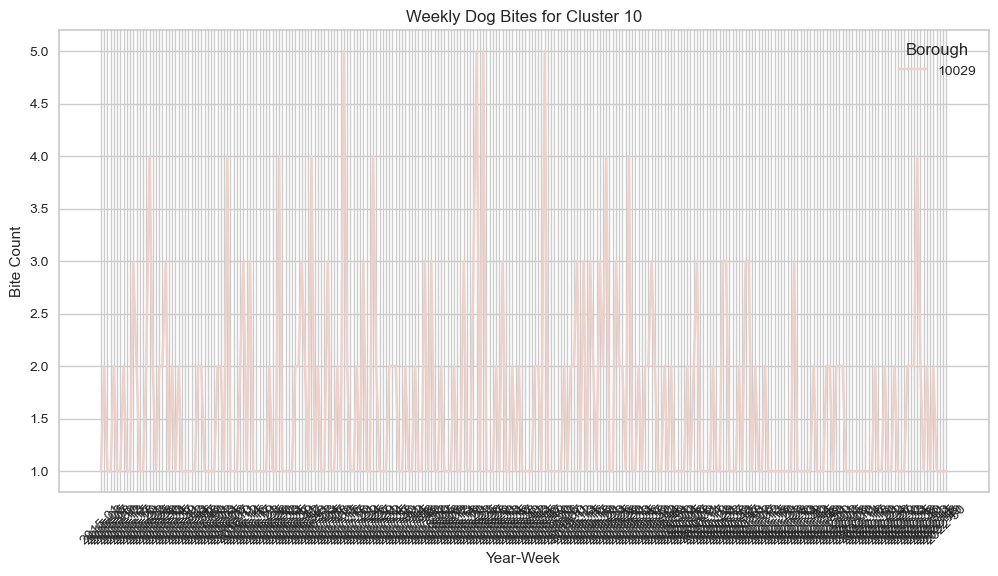

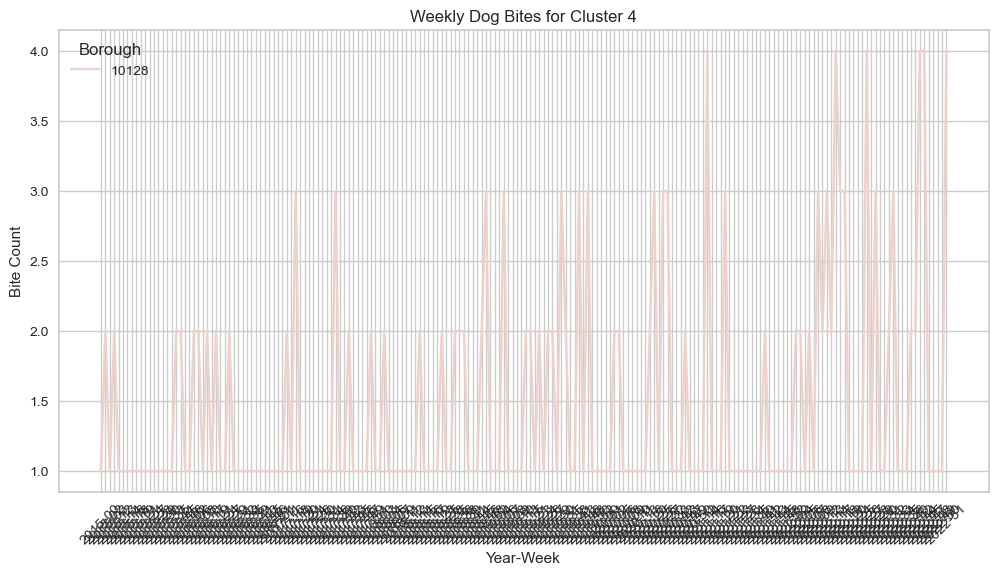

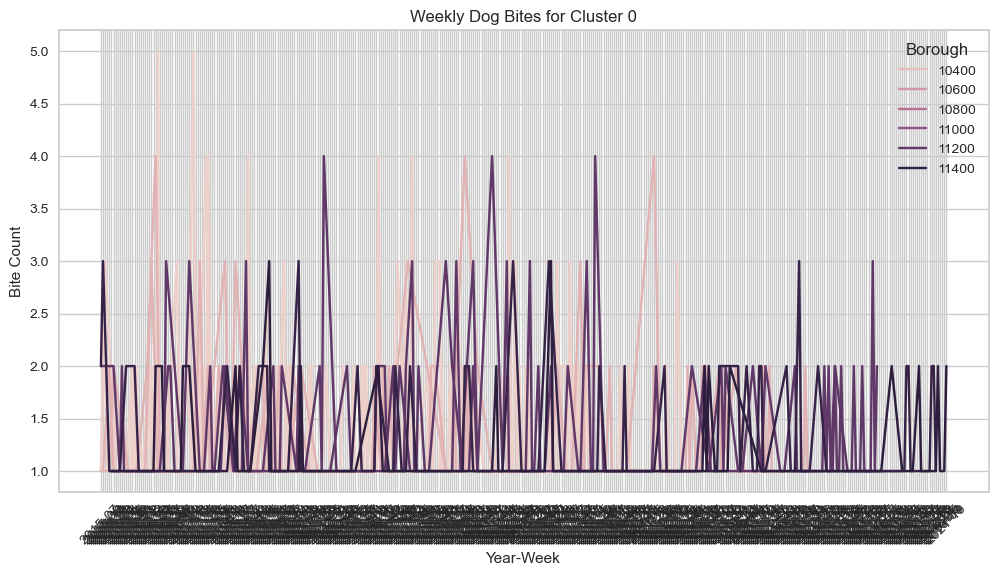

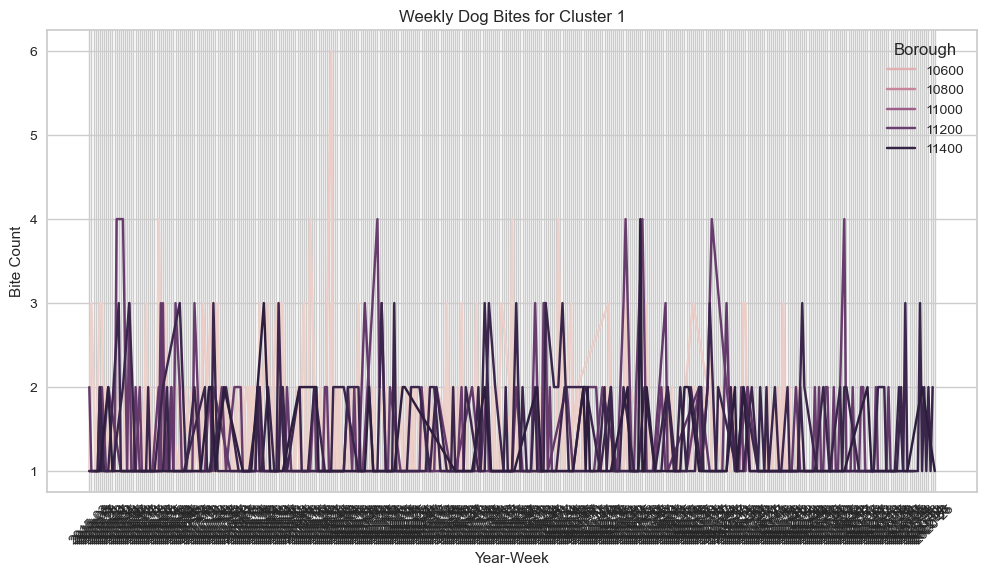

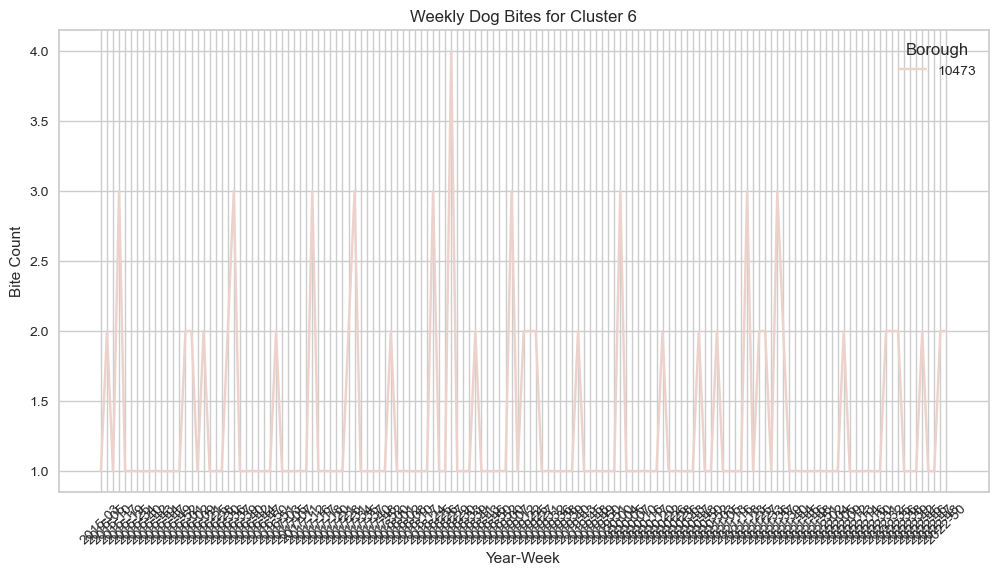

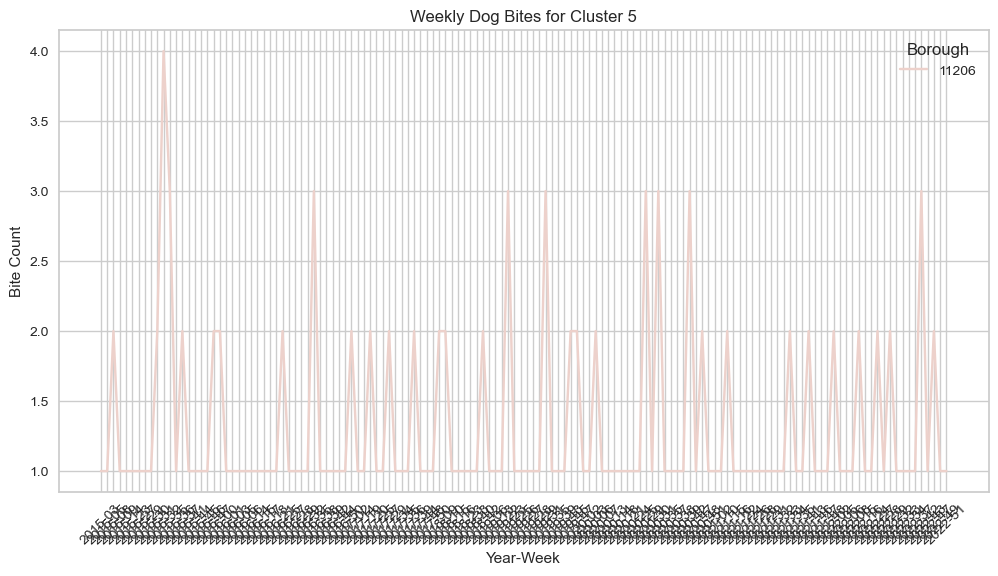

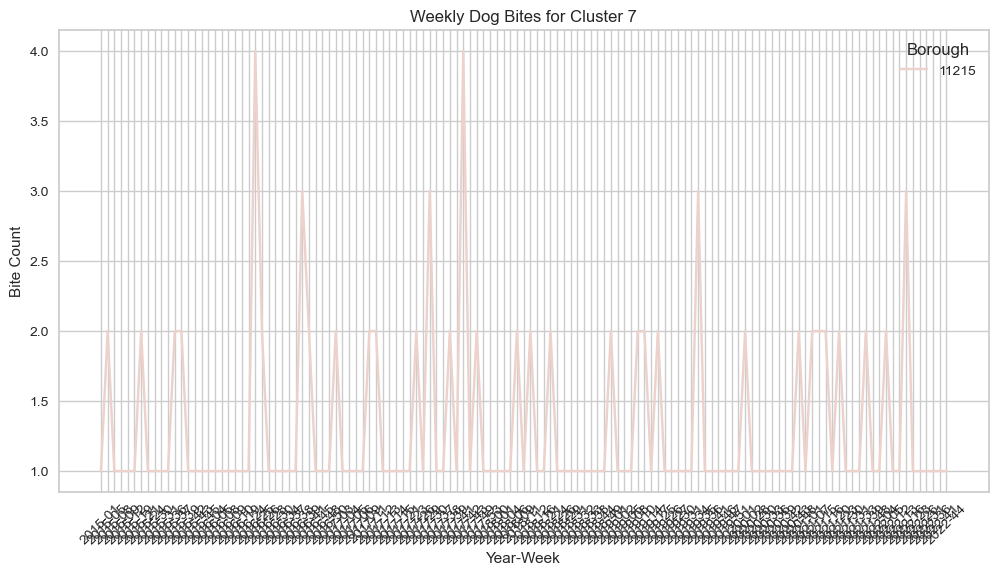

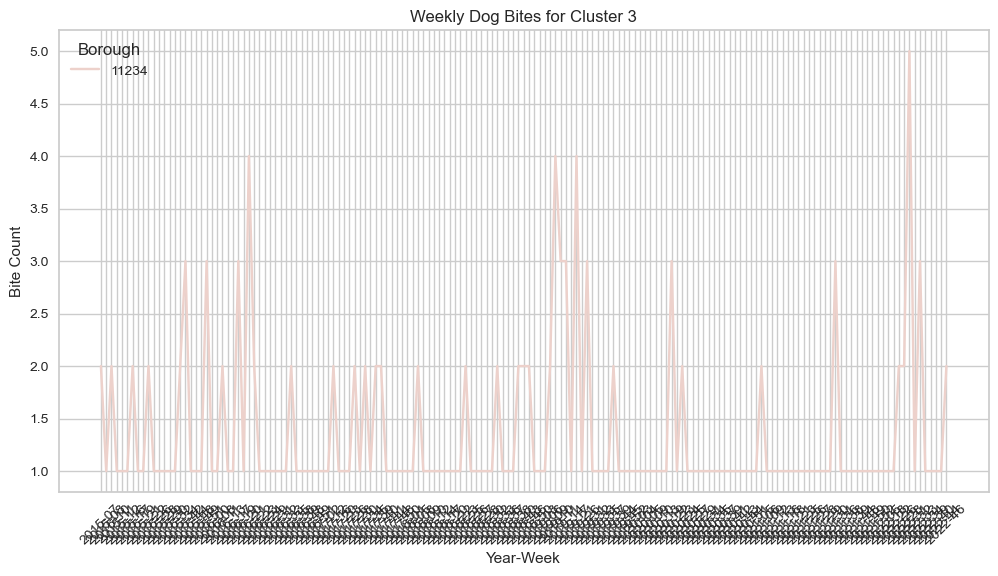

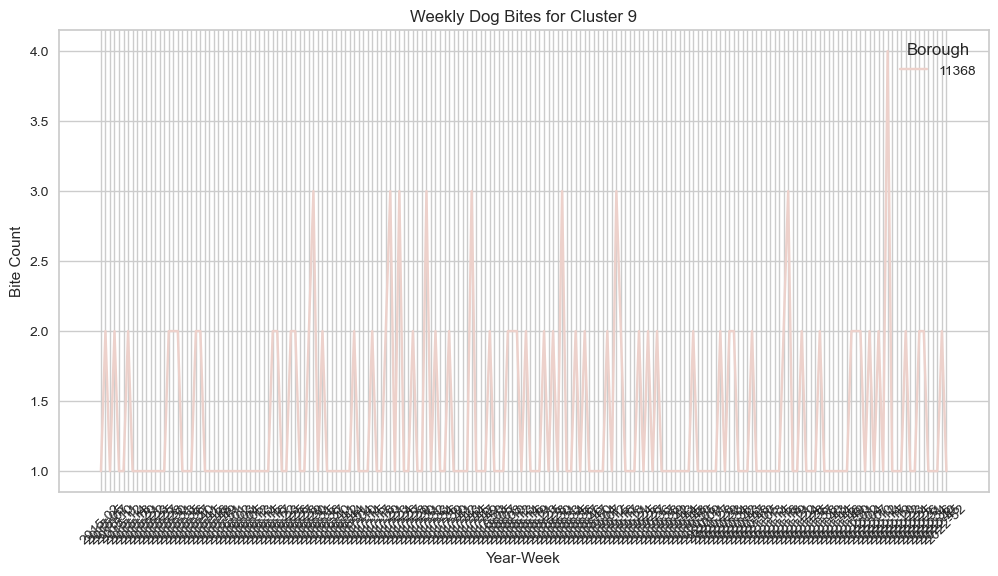

In [13]:
# Add cluster labels to the weekly_trends dataframe
weekly_trends = weekly_trends.merge(pivot_data[['cluster']], on='zip_code', suffixes=('', '_y'))

# Create a line plot for each cluster
for cluster in weekly_trends['cluster'].unique():
    plt.figure(figsize=(12, 6))
    cluster_data = weekly_trends[weekly_trends['cluster'] == cluster]
    sns.lineplot(data=cluster_data, x='year_week', y='bite_count', hue='zip_code')
    plt.title(f'Weekly Dog Bites for Cluster {cluster}')
    plt.xlabel('Year-Week')
    plt.ylabel('Bite Count')
    plt.xticks(rotation=45)
    plt.legend(title='Borough')
    plt.show()

In [16]:
# Save maps for each cluster
for cluster in pivot_data['cluster'].unique():
    heat_map = folium.Map(location=[40.7128, -74.0060], zoom_start=10)
    heat_data = wrangled[wrangled['zip_code'].isin(pivot_data[pivot_data['cluster'] == cluster].index)][['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data).add_to(heat_map)
    heat_map.save(f'../data/processed/zips/zip_code_map_cluster_{cluster}.html')